# Mean-variance optimization


The fundamental goal of portfolio theory is to optimally allocate our investments between different assets. Mean-variance optimization (MVO) is a quantitative tool that will allow to make this allocation by considering the trade-off between risk and return
In this Project, we work on several examples demonstrating PyPortfolioOpt's mean-variance capabilities.

We took 11 stocks prices from 6 diffrent Sectors i.e, IT, Health, Banking, Industrial,Communication, Real Estate, Auto

Some of the things we cover:

- Downloading data and getting it into PyPortfolioOpt
- Calculating and visualising the covariance matrix
- Optimising a long/short portfolio to minimise total variance
- Optimising a portfolio to maximise the Sharpe ratio, subject to sector constraints
- Optimising a portfolio to maximise return for a given risk, subject to sector constraints, with an L2 regularisation objective
- Optimising a market-neutral portfolio to minimise risk for a given level of return
- Optimising along the mean-semivariance frontier
- Optimising along the mean-CVaR frontier
- Plotting the efficient frontier:
    - Simple (using CLA)
    - Constrained
    - Complex plots


In [1]:
import numpy as np
import pandas as pd
import yfinance
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from fredapi import Fred
import yfinance as yf
import datetime

In [2]:
tickers = ["AAPL", "META", "GOOG", "AMZN", "UNH", 
           "BAC", "TMUS", "KO", "PLD", 
           "TSLA"]

In [3]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  10 of 10 completed


In [4]:
prices = ohlc["Adj Close"].dropna(how="any")
prices.tail(10)

,AAPL,AMZN,BAC,GOOG,KO,META,PLD,TMUS,TSLA,UNH
Date,,,,,,,,,,
2022-10-17,142.410004,113.790001,33.619999,100.779999,55.689999,134.039993,105.230003,133.839996,219.350006,521.880005
2022-10-18,143.750000,116.360001,34.880001,101.389999,56.439999,132.800003,105.849998,136.160004,220.190002,522.210022
2022-10-19,143.860001,115.070000,33.919998,100.290001,55.959999,133.229996,102.010002,135.740005,222.039993,520.320007
2022-10-20,143.389999,115.250000,33.700001,100.529999,55.080002,131.529999,102.459999,136.020004,207.279999,520.880005
2022-10-21,147.270004,119.320000,34.950001,101.480003,55.959999,130.009995,103.080002,136.460007,214.440002,533.729980
2022-10-24,149.449997,119.820000,35.070000,102.970001,57.570000,129.720001,103.370003,139.320007,211.250000,541.599976
2022-10-25,152.339996,120.599998,35.389999,104.930000,58.950001,137.509995,108.330002,140.630005,222.419998,540.219971
2022-10-26,149.350006,115.660004,35.700001,94.820000,59.389999,129.820007,109.870003,140.839996,224.639999,543.169983
2022-10-27,144.800003,110.959999,35.869999,92.599998,59.529999,97.940002,111.010002,140.630005,225.089996,541.799988


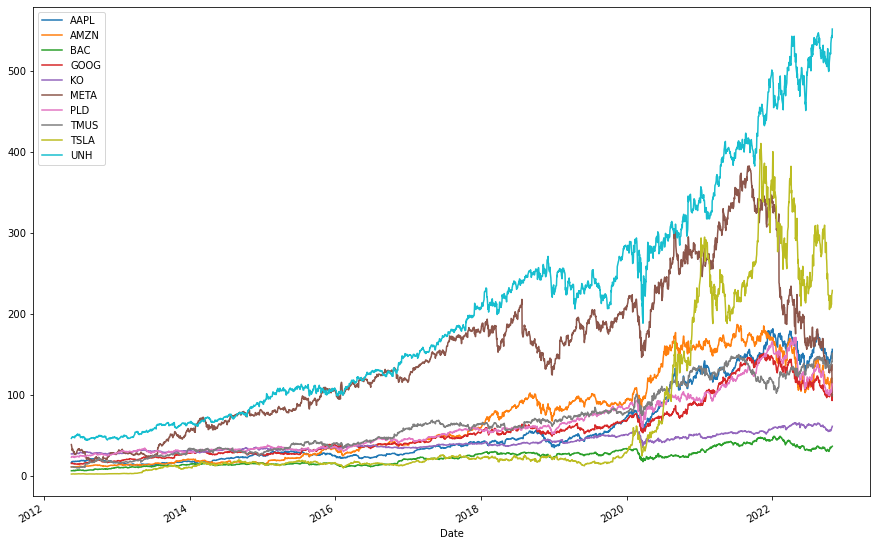

In [5]:
prices[prices.index >= "2004-01-01"].plot(figsize=(15,10));

 from the above graph it was clear that stock prices of apple was high and increasing since a decade

## Calculating the covariance matrix
 

In [6]:
import pypfopt
pypfopt.__version__

'1.5.3'

In addition to the expected returns, mean-variance optimization requires a risk model, some way of quantifying asset risk. The most commonly-used risk model is the covariance matrix, which describes asset volatilities and their co-dependence.

In [7]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(prices, frequency=252)
sample_cov

,AAPL,AMZN,BAC,GOOG,KO,META,PLD,TMUS,TSLA,UNH
AAPL,0.083300,0.045057,0.035628,0.042540,0.017691,0.049263,0.030061,0.027943,0.058912,0.029759
AMZN,0.045057,0.102102,0.031783,0.052276,0.013668,0.062237,0.028636,0.031536,0.065642,0.025349
BAC,0.035628,0.031783,0.097449,0.036039,0.023306,0.036954,0.032462,0.032326,0.044678,0.036059
GOOG,0.042540,0.052276,0.036039,0.070484,0.017303,0.056578,0.028121,0.029488,0.053087,0.028069
KO,0.017691,0.013668,0.023306,0.017303,0.032228,0.014387,0.023470,0.016952,0.017799,0.018626
META,0.049263,0.062237,0.036954,0.056578,0.014387,0.158756,0.029216,0.027681,0.063921,0.026990
PLD,0.030061,0.028636,0.032462,0.028121,0.023470,0.029216,0.060702,0.025362,0.033847,0.028359
TMUS,0.027943,0.031536,0.032326,0.029488,0.016952,0.027681,0.025362,0.104343,0.038447,0.024417
TSLA,0.058912,0.065642,0.044678,0.053087,0.017799,0.063921,0.033847,0.038447,0.318075,0.029915
UNH,0.029759,0.025349,0.036059,0.028069,0.018626,0.026990,0.028359,0.024417,0.029915,0.063312


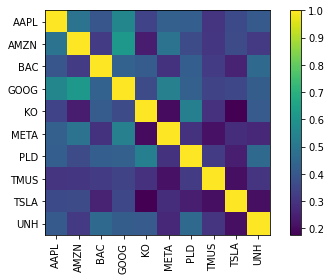

In [8]:
plotting.plot_covariance(sample_cov, plot_correlation=True);

the sample covariance matrix should not be the only default choice. I think a better option is Ledoit-Wolf shrinkage, which reduces the extreme values in the covariance matrix. In the image below, we can see that there are fewer bright spots outside the diagonal:

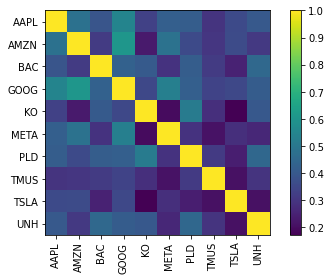

In [9]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
plotting.plot_covariance(S, plot_correlation=True);

## Return estimation
It is often a bad idea to provide returns using a simple estimate like the mean of past returns. Unless you have a proprietary method for estimating returns, research suggests that it may be better off not providing expected returns – it can then just find the min_volatility() portfolio or use HRP.

However, in this example we will use the CAPM returns, which aims to be slightly more stable than the default mean historical return. 

In [10]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(prices)
mu

AAPL    0.275465
AMZN    0.298651
BAC     0.267276
GOOG    0.271715
KO      0.138827
META    0.339813
PLD     0.214713
TMUS    0.237975
TSLA    0.460409
UNH     0.209009
Name: mkt, dtype: float64

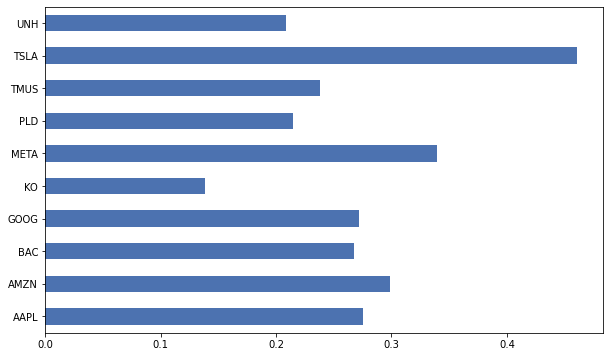

In [11]:
mu.plot.barh(figsize=(10,6));


The returns of Tesla is more compared to others

## Long/short min variance
In this section, we construct a long/short portfolio with the objective of minimising variance. There is a good deal of research that demonstrates that these global-minimum variance (GMV) portfolios outperform mean-variance optimized portfolios

In [12]:
from pypfopt import EfficientFrontier

In [13]:
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

# we don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(None, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.04534),
             ('AMZN', 0.06349),
             ('BAC', -0.01553),
             ('GOOG', 0.05808),
             ('KO', 0.58451),
             ('META', 0.01903),
             ('PLD', 0.04684),
             ('TMUS', 0.07399),
             ('TSLA', -0.00742),
             ('UNH', 0.13167)])

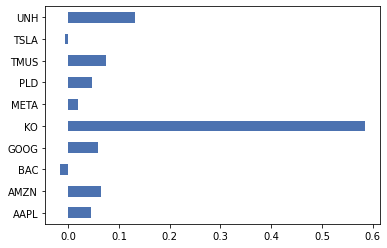

In [14]:
pd.Series(weights).plot.barh();

We can get a quick indication of the portfolio performance as follows. that this is an in sample estimate and may have very little resemblance to how the portfolio actually performs

In [15]:
ef.portfolio_performance(verbose=True);

Annual volatility: 16.3%


In [16]:
prices

,AAPL,AMZN,BAC,GOOG,KO,META,PLD,TMUS,TSLA,UNH
Date,,,,,,,,,,
2012-05-18,16.173407,10.692500,5.978322,14.953949,26.670553,38.230000,22.695282,10.588834,1.837333,45.897869
2012-05-21,17.115669,10.905500,5.816515,15.295419,26.836231,34.029999,23.627171,10.621976,1.918000,47.224037
2012-05-22,16.984245,10.766500,5.944256,14.963912,26.720978,31.000000,23.333668,10.638548,2.053333,47.368576
2012-05-23,17.398653,10.864000,6.106064,15.179603,26.850645,32.000000,23.451071,10.655118,2.068000,47.062523
2012-05-24,17.238867,10.762000,6.080515,15.035145,27.214413,33.029999,23.318991,10.671689,2.018667,47.793625
...,...,...,...,...,...,...,...,...,...,...
2022-10-24,149.449997,119.820000,35.070000,102.970001,57.570000,129.720001,103.370003,139.320007,211.250000,541.599976
2022-10-25,152.339996,120.599998,35.389999,104.930000,58.950001,137.509995,108.330002,140.630005,222.419998,540.219971
2022-10-26,149.350006,115.660004,35.700001,94.820000,59.389999,129.820007,109.870003,140.839996,224.639999,543.169983


Let's say we were happy with this portfolio and wanted to actually go out and buy the shares. To do this, we would need to construct a discrete allocation (unless your broker supports fractional shares!)

If we had $20,0000 to invest and would like our portfolio to be 130/30 long/short, we can construct the actual allocation as follows:

In [17]:
from pypfopt import DiscreteAllocation

latest_prices = prices.iloc[-1]  # prices as of the day you are allocating
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=20000, short_ratio=0.3)
alloc, leftover = da.lp_portfolio()
print(f"Discrete allocation performed with ${leftover:.2f} leftover")
alloc

Discrete allocation performed with $196.39 leftover


C:\Users\Rashmitha\anaconda3\lib\site-packages\cvxpy\problems\problem.py:1337: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


{'AMZN': 13,
 'GOOG': 13,
 'KO': 190,
 'META': 5,
 'PLD': 9,
 'TMUS': 10,
 'UNH': 5,
 'BAC': -112,
 'TSLA': -8}

## Max Sharpe with sector constraints
If you have your own model for returns (or have read the warnings and want to proceed anyways), you may consider maximising the Sharpe ratio. This theoretically gives the optimal portfolio in terms of risks-returns.

In this section, we construct a long-only max-sharpe portfolio, but also incorporate sector constraints. Sector constraints require three things. A sector_mapper, your sector_lower bounds, and your sector_upper bounds.

In [18]:
sector_mapper = {
    "AAPL": "Information Sector",
    "GOOG": "Information Sector",
    "AMZN": "Information Sector",
    "KO": "Industrial Sector",
    "META": "Information Sector",
    "TMUS": "Communication ",
    "TSLA": "Auto",
    "UNH": "Health Sector",
    "BAC": "Banking Sector",
    "PLD": "Real Estate"
}

sector_lower = {
    "Information Sector": 0.10, # at least 10% to Information sect
    "Auto": 0.1 # at least 5% to auto
    # For all other sectors, it will be assumed there is no lower bound
}

sector_upper = {
    "Health Sector": 0.3,
    "Industrial Sector":0.1,
    "Banking Sector": 0.1,
    "Real Estate":0.1
}

We then set up the optimizer and add our constraints. We can use ef.add_objective() to add other constraints. For example, let's say that in addition to the above sector constraints, I specifically want:

10% of the portfolio in AMZN

Less than 5% of my portfolio in TSLA


In [20]:
mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S)  # weight_bounds automatically set to (0, 1)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

amzn_index = ef.tickers.index("AAPL")
ef.add_constraint(lambda w: w[amzn_index] == 0.10)

tsla_index = ef.tickers.index("TSLA")
ef.add_constraint(lambda w: w[tsla_index] <= 0.10)

ef.add_constraint(lambda w: w[9] >= 0.05)

ef.max_sharpe()
weights = ef.clean_weights()

In [21]:
weights


OrderedDict([('AAPL', 0.1),
             ('AMZN', 0.10037),
             ('BAC', 0.1),
             ('GOOG', 0.10047),
             ('KO', 0.09837),
             ('META', 0.10043),
             ('PLD', 0.1),
             ('TMUS', 0.10023),
             ('TSLA', 0.1),
             ('UNH', 0.10013)])

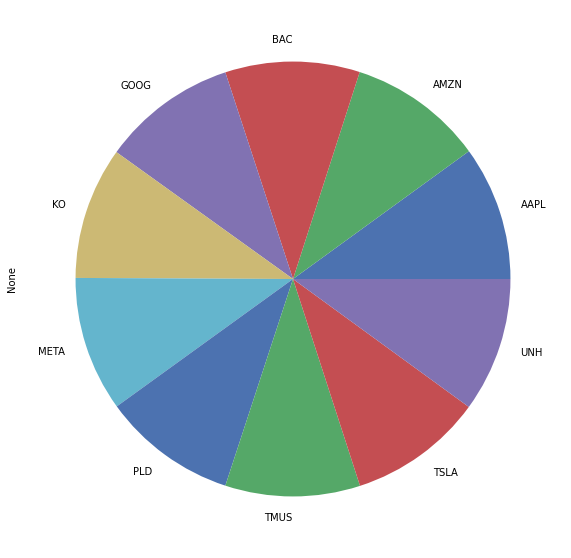

In [22]:
pd.Series(weights).plot.pie(figsize=(10,10));

We can immediately see that our explicit constraints were satisfied, and can check all the sector constraints as follows:

In [23]:
for sector in set(sector_mapper.values()):
    total_weight = 0
    for t,w in weights.items():
        if sector_mapper[t] == sector:
            total_weight += w
    print(f"{sector}: {total_weight:.3f}")

Information Sector: 0.401
Real Estate: 0.100
Industrial Sector: 0.098
Banking Sector: 0.100
Auto: 0.100
Communication : 0.100
Health Sector: 0.100


## Maximise return for a given risk, with L2 regularisation
Let's imagine that we've put a lot of thought into our risk tolerance, and have decided that we can't accept anything more than 20% volatility. We can use PyPortfolioOpt to construct a portfolio that maximises return for a given risk (with the same caveats about expected returns).

In [30]:
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.efficient_risk(target_volatility=0.20)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.09496),
             ('AMZN', 0.0902),
             ('BAC', 0.09163),
             ('GOOG', 0.10375),
             ('KO', 0.1),
             ('META', 0.08511),
             ('PLD', 0.1),
             ('TMUS', 0.10535),
             ('TSLA', 0.1),
             ('UNH', 0.129)])

In [31]:
num_small = len([k for k in weights if weights[k] <= 1e-4])
print(f"{num_small}/{len(ef.tickers)} tickers have zero weight")

0/10 tickers have zero weight


In [32]:
ef.portfolio_performance(verbose=True);

Expected annual return: 26.8%
Annual volatility: 20.0%
Sharpe Ratio: 1.24


While this portfolio seems like it meets our objectives, we might not to be worried by the fact that a lot of the tickers have not been assigned zero weight. In effect, the optimizer is "goodfitting" to the data which have provided  But you are much more likely to get better results by enforcing some level of diversification. One way of doing this is to use L2 regularisation – essentially, adding a penalty on the number of near-zero weights.

In [33]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.20)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.09647),
             ('AMZN', 0.09059),
             ('BAC', 0.09455),
             ('GOOG', 0.10222),
             ('KO', 0.1),
             ('META', 0.08314),
             ('PLD', 0.1),
             ('TMUS', 0.10685),
             ('TSLA', 0.1),
             ('UNH', 0.1262)])

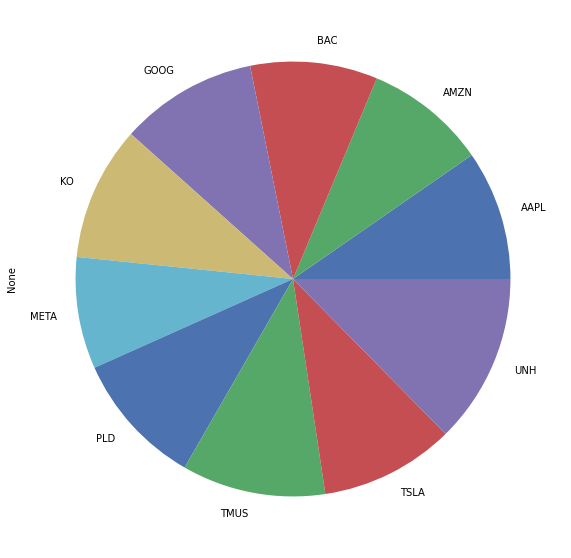

In [34]:
pd.Series(weights).plot.pie(figsize=(10, 10));

In [35]:
ef.portfolio_performance(verbose=True);

Expected annual return: 26.8%
Annual volatility: 20.0%
Sharpe Ratio: 1.24


The resulting portfolio still has a volatility of less than our 20% limit. It's in-sample Sharpe ratio has been same and return also same. so the L2 regularization also got same result

 ## Minimise risk for a given return, market-neutral
We may instead be in the situation where we have a certain required rate of return (maybe we are a pension fund that needs 7% return a year), but would like to minimise risk. Additionally, suppose we would like our portfolio to be market neutral, in the sense that it is equally exposed to the long and short sides.

In [36]:
# Must have no weight bounds to allow shorts
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))
ef.add_objective(objective_functions.L2_reg)
ef.efficient_return(target_return=0.07, market_neutral=True)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.00685),
             ('AMZN', 0.03107),
             ('BAC', 0.00236),
             ('GOOG', 0.00247),
             ('KO', -0.15043),
             ('META', 0.07653),
             ('PLD', -0.05908),
             ('TMUS', -0.0318),
             ('TSLA', 0.18758),
             ('UNH', -0.06555)])

In [37]:
ef.portfolio_performance(verbose=True);

Expected annual return: 7.0%
Annual volatility: 11.6%
Sharpe Ratio: 0.43


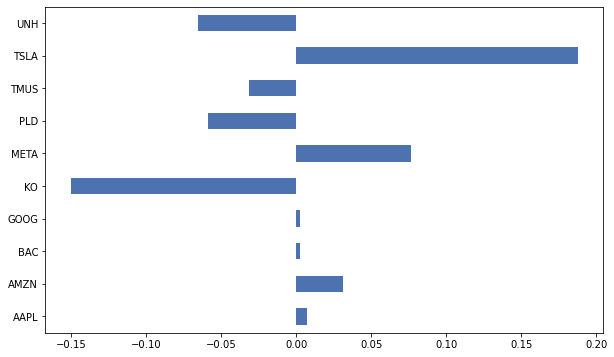

In [38]:
pd.Series(weights).plot.barh(figsize=(10,6));

In [39]:
print(f"Net weight: {sum(weights.values()):.2f}")

Net weight: 0.00


## Efficient semi-variance optimization
In this example, we will minimise the portfolio semivariance (i.e downside volatility) subject to a return constraint (target 20%).

There are actually two ways of doing this in PyPortfolioOpt. The first is the "intuitive" way. We compute a semicovariance matrix, and pass this into EfficientFrontier (just like we would do for the exponential cov matrix or the Ledoit-Wolf shrunk matrix).

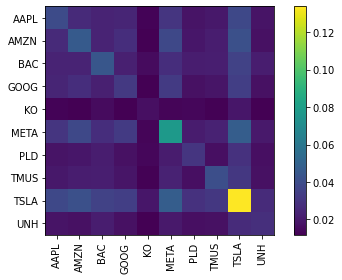

In [40]:
semicov = risk_models.semicovariance(prices, benchmark=0)
plotting.plot_covariance(semicov);

In [41]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.2)
weights = ef.clean_weights()
weights


OrderedDict([('AAPL', 0.04895),
             ('AMZN', 0.05357),
             ('BAC', 0.0),
             ('GOOG', 0.17979),
             ('KO', 0.43975),
             ('META', 0.0),
             ('PLD', 0.06601),
             ('TMUS', 0.07417),
             ('TSLA', 0.0),
             ('UNH', 0.13776)])

In [42]:
ef.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual volatility: 12.7%
Sharpe Ratio: 1.41


However, this solution is not truly optimal in mean-semivariance space. To do the optimization properly, we must use the EfficientSemivariance class. This requires us to first compute the returns and drop NaNs.

In [43]:
returns = expected_returns.returns_from_prices(prices)
returns = returns.dropna()

In [44]:
from pypfopt import EfficientSemivariance

es = EfficientSemivariance(mu, returns)
es.efficient_return(0.2)
es.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual semi-deviation: 11.6%
Sortino Ratio: 1.55


To compare this with the heuristic solution, I will use a quick hack: replacing the es.weights with es.weights and running es.portfolio_performance again. Please don't be encouraged to do this in real life!

In [45]:
es.weights = ef.weights
es.portfolio_performance(verbose=True);

Expected annual return: 20.0%
Annual semi-deviation: 11.6%
Sortino Ratio: 1.55


We see that the heuristic method has a significantly lower Sortino ratio, and much higher semivariance.

 ## Efficient CVaR optimization
In this example, we will find the portfolio that maximises return subject to a CVaR constraint.

Before doing this, let's first compute the 95%-CVaR for the max-sharpe portfolio.

In [46]:
returns = expected_returns.returns_from_prices(prices).dropna()
returns.head()


,AAPL,AMZN,BAC,GOOG,KO,META,PLD,TMUS,TSLA,UNH
Date,,,,,,,,,,
2012-05-21,0.058260,0.019921,-0.027066,0.022835,0.006212,-0.109861,0.041061,0.003130,0.043904,0.028894
2012-05-22,-0.007679,-0.012746,0.021962,-0.021674,-0.004295,-0.089039,-0.012422,0.001560,0.070559,0.003061
2012-05-23,0.024400,0.009056,0.027221,0.014414,0.004853,0.032258,0.005031,0.001558,0.007143,-0.006461
2012-05-24,-0.009184,-0.009389,-0.004184,-0.009517,0.013548,0.032187,-0.005632,0.001555,-0.023855,0.015535
2012-05-25,-0.005360,-0.010918,0.001401,-0.020094,-0.004367,-0.033909,-0.008811,0.012422,-0.015522,-0.001779


In [47]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 27.2%
Annual volatility: 20.3%
Sharpe Ratio: 1.24


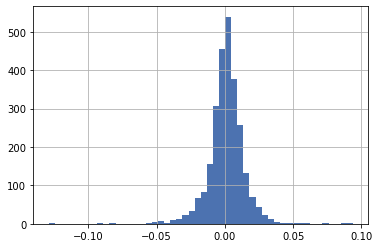

In [48]:
portfolio_rets = (returns * weight_arr).sum(axis=1)
portfolio_rets.hist(bins=50);

In [49]:
var = portfolio_rets.quantile(0.05)
cvar = portfolio_rets[portfolio_rets <= var].mean()
print("VaR: {:.2f}%".format(100*var))
print("CVaR: {:.2f}%".format(100*cvar))

VaR: -1.94%
CVaR: -3.06%


This value of the CVaR means that our average loss on the worst 5% of days will be -3.03%. Let's say that this were beyond our comfort zone (for a $100,000 portfolio, this would mean losing $3030 in a day).

Let's firstly construct the portfolio with the minimum CVaR:

In [50]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.min_cvar()
ec.portfolio_performance(verbose=True);


Expected annual return: 18.1%
Conditional Value at Risk: 2.39%


We have significantly reduced the CVaR, but at the cost of a large reduction in returns. We can use efficient_risk to maximise the return for a target risk. Let's say that a 2.5% CVaR is acceptable.

In [51]:
from pypfopt import EfficientCVaR

ec = EfficientCVaR(mu, returns)
ec.efficient_risk(target_cvar=0.025)
ec.portfolio_performance(verbose=True);

Expected annual return: 21.6%
Conditional Value at Risk: 2.50%


We now have  returns of (27.2% vs 21.6%), but with a lower tail risk (2.50% CVaR vs 3.06%).

# Plotting - Unconstrained 

To plot the unconstrained efficient frontier, it is easiest to use the critical line algorithm.



In [52]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 26.2%
Annual volatility: 19.5%
Sharpe Ratio: 1.24


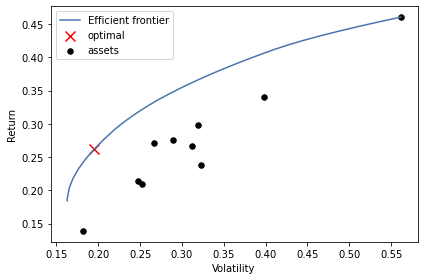

In [53]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)

# Plotting - Constrained
In this example, we will plot the efficient frontier corresponding to portfolios with a constraint on exposure to AAPL, AMZN, and TSLA (e.g maybe we want to avoid big tech) 

In [54]:
import cvxpy as cp

mu = expected_returns.capm_return(prices)
S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()

ef = EfficientFrontier(mu, S,)
big_tech_indices = [t in {"AAPL", "AMZN", "TSLA"} for t in tickers]
ef.add_constraint(lambda w: cp.sum(w[big_tech_indices]) <= 0.3)

 before we call any optimization function, we should pass this to the plotting module

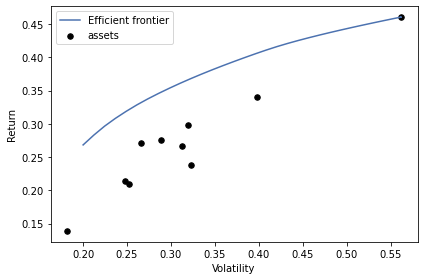

In [55]:
ax = plotting.plot_efficient_frontier(ef, ef_param="risk", 
                                      ef_param_range=np.linspace(0.2, 0.8, 50), 
                                      showfig=False);

# Complex plots
The plotting module allows you to pass in an ax, on top of which the plots are added. This allows you to build complex plots.

In this example, we will plot the efficient frontier as well as 10,000 simulated portfolios.

To generate the simulated portfolios, we will sample random weights from the Dirichlet distribution (these are already normalised):

In [56]:
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt((w.T * (S @ w.T)).sum(axis=0))
sharpes = rets / stds

print("Sample portfolio returns:", rets)
print("Sample portfolio volatilities:", stds)

Sample portfolio returns: [0.24573717 0.24238275 0.28247984 ... 0.30528516 0.26614908 0.29047336]
Sample portfolio volatilities: 0       0.190693
1       0.188765
2       0.215284
3       0.193161
4       0.284861
          ...   
9995    0.233339
9996    0.207630
9997    0.280419
9998    0.213428
9999    0.234357
Length: 10000, dtype: float64


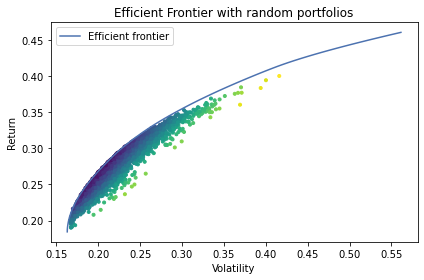

In [57]:
# Plot efficient frontier with Monte Carlo sim
ef = EfficientFrontier(mu, S)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef2 = EfficientFrontier(mu, S)
ef2.max_sharpe()
ret_tangent, std_tangent, _ = ef2.portfolio_performance()

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()

the graph gives a better idea of what the efficient frontier is. In the graph above, we see that the efficient frontier is like a boundary. i.e. It is not possible for portfolios to lie above the frontier (else we would have portfolios with the same volatility as those on the frontier but with higher expected returns). It is also not possible for portfolios to lie at the left of the frontier (else we would have portfolios with the same expected returns as those on the frontier but with lower volatility).

